# Jet dataset: a walk-through

The Large Hadron Collider (LHC) is pushing for higher energy of collisions. The current objective is to collect 10$\times$ more data than in the initial design by around 2030. This urges the experiments to upgrade their infrastructure and implement more complex algorithms early in physics event selection process. We will exploit fast inference neural networks suitable for the implementation in the Compact Muon Solenoid (CMS) trigger system. Our case study is a jet detection task using tracker data and calorimeter energy deposits. This notebook provides a walk through basics on jets, trigger system and calorimeters. It gives a general overview of the dataset used by the algorithm and visualizes the training data.

In [1]:
# Before starting import everything necessary
import numpy as np
import uproot3 as uproot
import simplejson as json

from uproot3_methods import TLorentzVectorArray

In [2]:
# Set presentation settings
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from mpl_toolkits import mplot3d

with open('../plots/palette.json') as json_file:
    color_palette = json.load(json_file)
plt.style.use('../plots/ssdjet.mplstyle')

In [3]:
# Set the source paths
FILE_CONFIGURATION = '../data/file-configuration.json'
SOURCE_PATH = '/eos/project/d/dshep/CEVA'
EXAMPLE_FILE = 'RSGraviton_WW_NARROW_PU50_PF/RSGraviton_WW_NARROW_PU50_PF_0.root'

## Jets

A jet is a collimated spray of particles, it is used to probe the underlying elementary particle that initiates the cascade of particles.

In [4]:
# Print available jet events
with open(FILE_CONFIGURATION, 'r') as f:
    config = json.loads(f.read())    

for dataset in ['RSGraviton_HH_NARROW_PU50_PF',
                'RSGraviton_WW_NARROW_PU50_PF',
                'RSGraviton_ZZ_NARROW_PU50_PF',
                'RSGraviton_bb_NARROW_PU50_PF',
                'RSGraviton_gg_NARROW_PU50_PF',
                'RSGraviton_qq_NARROW_PU50_PF',
                'RSGraviton_tt_NARROW_PU50_PF']:
    print('{0}: {1} events'.format(dataset, config['{0}/{1}'.format(SOURCE_PATH, dataset)]['events']))

RSGraviton_HH_NARROW_PU50_PF: 1000000 events
RSGraviton_WW_NARROW_PU50_PF: 1000000 events
RSGraviton_ZZ_NARROW_PU50_PF: 1000000 events
RSGraviton_bb_NARROW_PU50_PF: 980000 events
RSGraviton_gg_NARROW_PU50_PF: 990000 events
RSGraviton_qq_NARROW_PU50_PF: 980000 events
RSGraviton_tt_NARROW_PU50_PF: 990000 events


In [5]:
# Define jet properties by class
SETTINGS = {'t': {'id': 0, 'radius': 46, 'pid': [6], 'cut_m': [105., 210.]},
            'V': {'id': 1, 'radius': 46, 'pid': [23, 24], 'cut_m': [65., 105.]},
            'H': {'id': 2, 'radius': 46, 'pid': [25], 'cut_m': [105., 140.]}}

## Calorimeters

Calorimeters are devices that measure the energy of the long-lived particles. CMS has two types of calorimeters: electromagentic (ECAL) and hadron (HCAL). ECAL is responsible for measuring the energy of electrons and photons. Neutral particles (e.g. photons) are not visible in tracking devices but revealed by the energy deposit they leave in the calorimeters. ECAL is made of 76000 scintillating PbWO$_4$ crystals. HCAL measures the energy of long-lived charged and neutral hadrons. Hadrons begin to lose energy in ECAL only to be stopped in HCAL. The calorimeters have a finite segmentation in pseudo-rapidity $\eta$ and azimuthal angle $\phi$. The coordinate of the resulting calorimeter energy deposit, the tower, is computed as the geometrical centre of the cell.

Number of non-zero towers: 1367


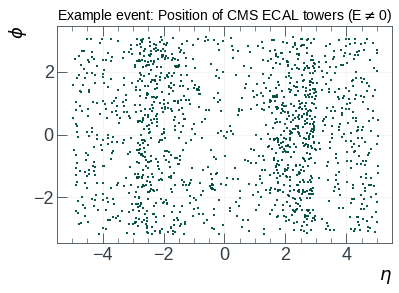

In [6]:
# Placement of non-zero towers in an example event
file = uproot.open('%s/%s' % (SOURCE_PATH, EXAMPLE_FILE))
print('Number of non-zero towers: {0}'.format(file['Delphes']['EFlowPhoton']['EFlowPhoton.ET'].array()[0].shape[0]))

plt.xlabel('$\eta$', horizontalalignment='right', x=1.0)
plt.ylabel('$\phi$', horizontalalignment='right', y=1.0)
plt.scatter(file['Delphes']['EFlowPhoton']['EFlowPhoton.Eta'].array()[0],
            file['Delphes']['EFlowPhoton']['EFlowPhoton.Phi'].array()[0],
            color=color_palette['teal']['shade_900'],
            marker='s', s=1);
plt.title('Example event: Position of CMS ECAL towers (E$\\neq$0)')
plt.show();

## Trigger System

Each LHC event corresponds to around 1 MB in unprocessed form. The LHC operates at the rate of 40 MHz. Thus, the LHC is one of the largest sources of data in the world. Trigger system selects only interesting events due to storage constrains. Trigger system is essentially a hierarchical set of algorithms:
* The Level 1 (L1) Trigger, reduces the 40 MHz input to a 100 kHz rate. It is implemented on FPGAs and ASICs with approximately 3.2 $\mu$s to decide.
* High Level Trigger (HLT) scales the 100 kHz stream from L1 Trigger rate down to 1 kHz. It is a collision reconstruction software running on a computer farm of about one thousand commercial processors. The decision has to happen in approximately 100 ms.
Jet triggers are primarly designed to study quantum chromodynamics (QCD), but also be used for many analysis, such as searches for new physics. We will use data from the central region of the CMS calorimetes -3 < $\eta$ < +3. The regions |$\eta$| >= 3 belong to forward calorimeter.

In order to transform calorimeter energy deposits to an image we need to define grid edges of the continues variables $\phi$ and $\eta$ to map them to pixel coorinates.

In [8]:
# Define central region and jet data
MIN_ETA, MAX_ETA = -3, +3

# Grid edges
def get_edges(edges_file, edge_index, sample_events=1000):
    global_edges = np.array([], dtype=np.float32)
    for i in range(sample_events):
        global_edges = np.append(global_edges, edges_file[i][:,edge_index]) # Add left edge
        global_edges = np.append(global_edges, edges_file[i][:,edge_index+1]) # Add right edge
        global_edges = np.unique(global_edges)
    return global_edges

file = uproot.open('{0}/{1}'.format(SOURCE_PATH, EXAMPLE_FILE))
towers = file['Delphes']['EFlowPhoton']['EFlowPhoton.Edges[4]'].array()

edges_eta_ecal = get_edges(towers, edge_index=0)
edges_eta_ecal = edges_eta_ecal[(edges_eta_ecal > MIN_ETA) &
                                (edges_eta_ecal < MAX_ETA)]
edges_phi_ecal = get_edges(towers, edge_index=2)

## Generating Input Dataset

Our dataset is generated with Delphes. The goal of Delphesis to allow the simulation of a multipurpose detector for phenomenological studies. The simulation includes a tracking system, embedded into a magnetic field, calorimeters and a muon system. Source: https://arxiv.org/abs/1307.6346

In [9]:
# Plotting calorimeter energy deposit image (3d / 2d view)
def plot_calo_deposits(labels, data2d, data3d, label, scale='$E_T$ [GeV]'):
    
    offset = 15
    
    fig = plt.figure(figsize=(14.0, 6.0))   
    cmap = matplotlib.cm.viridis

    # 3D Plot Energy Deposit
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    eta, phi, energy = data3d
    colours = matplotlib.cm.viridis(energy/np.log10(max(energy)))
    width = depth = .1
    ax.bar3d(eta,
             phi,
             np.zeros_like(energy),
             width,
             depth,
             energy,
             color=colours,
             shade=True)
    ax.set_xlabel('$\eta$')
    ax.set_ylabel('$\phi$')
    ax.set_zlabel(scale)
    ax.view_init(10, 40);
    
    # 2D Plot Energy Deposit
    ax = fig.add_subplot(1, 2, 2)
    
    ax.text(0, 1.05, 'CMS', weight='bold',
            verticalalignment='top', horizontalalignment='left', transform=ax.transAxes,
            color='black', fontsize=16)

    ax.set_title(label, loc='right')
    ax.set_xlim([-offset, data2d.shape[0]+offset])
    ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
    ax.set_ylim([-offset, data2d.shape[1]+offset])
    ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)

    im = ax.imshow(data2d.T,
                   norm=SymLogNorm(linthresh=0.03,
                                   vmin=0,
                                   vmax=data2d.max()),
                   interpolation='nearest',
                   cmap=cmap)
    
    for label in labels:
        jet = patches.Rectangle((label[1], label[2]),
                                label[3]-label[1],
                                label[4]-label[2],
                                linewidth=2,
                                edgecolor=color_palette['red']['shade_600'],
                                facecolor='none')
        ax.add_patch(jet)
        ax.text(label[1],
                 label[4],
                 '{}: {:.0f} GeV/c'.format(label[0], label[5]),
                 weight='bold',
                 color='#FAFAFA',
                 bbox={'facecolor': color_palette['red']['shade_900'], 'alpha': 1.0})

    cbar = fig.colorbar(im, extend='max')
    cbar.set_label(scale, rotation=90, horizontalalignment='right', y=1.0)

    plt.show();

In [10]:
# Plotting calorimeter energy deposit image in color
def calorimeter_image(labels, baselines, data2d, titles=[]):
    offset = 15
    fig = plt.figure(figsize=(14.0, 6.0))
    for i, (label, title) in enumerate(zip([labels, baselines], titles)):
        ax = plt.subplot(1, 2, i+1)
        ax.set_title(title, loc='right')
        ax.set_xlim([-offset, data2d.shape[1]+offset])
        ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
        ax.set_ylim([-offset, data2d.shape[0]+offset])
        ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)
        ax.imshow(data2d)

        for l in label:
            jet = patches.Rectangle((l[1], l[2]),
                                    l[3]-l[1],
                                    l[4]-l[2],
                                    linewidth=2,
                                    edgecolor=color_palette['red']['shade_600'],
                                    facecolor='none')
            ax.add_patch(jet)
            ax.text(l[1], l[4],
                    '{}: {:.0f} GeV/c'.format(l[0], l[-1]),
                    weight='bold',
                    color='#FAFAFA',
                    bbox={'facecolor': color_palette['red']['shade_900'], 'alpha': 1.0})
    plt.show();

In [11]:
# Match calorimeter deposit with a pixel
def get_energy_map(etas, phis, pts):
    histogram, _, _ = np.histogram2d(etas, phis, bins=[edges_eta_ecal, edges_phi_ecal], weights=pts)
    return histogram, np.argwhere(histogram)

In [12]:
# Method to process ground truth labels
def get_labels(check_labels, status, pids, etas, phis, pts):
    labels = np.empty((0, 6))
    pids = np.abs(pids)
    for label in check_labels:
        jid = SETTINGS[label]['id']
        pid = SETTINGS[label]['pid']
        for e, p, pt, s in zip(etas[np.isin(pids, pid)],
                               phis[np.isin(pids, pid)],
                               pts[np.isin(pids, pid)],
                               status[np.isin(pids, pid)]):
            if s == 22:
                e = np.argmax(edges_eta_ecal >= e) - 1
                p = np.argmax(edges_phi_ecal >= p) - 1

                xmin = int(e-SETTINGS[label]['radius']/2)
                xmax = int(e+SETTINGS[label]['radius']/2)
                ymin = int(p-SETTINGS[label]['radius']/2)
                ymax = int(p+SETTINGS[label]['radius']/2)

                labels = np.vstack((labels, [jid, xmin, ymin, xmax, ymax, pt]))
    return labels

In [18]:
# Method to process baseline
def get_baseline(check_labels, j, taus, etas, phis, pts):
    baselines = np.empty((0, 6))
    m = TLorentzVectorArray.from_cartesian(j.fX, j.fY, j.fZ, j.fE).mass
    m = np.nan_to_num(m)
    taus = np.nan_to_num(taus)
    taus = np.where(taus == 0, 10**-6, taus)
    tau21 = taus[:, 1] / taus[:, 0]
    tau32 = taus[:, 2] / taus[:, 1]
    for label in check_labels:
        jid = SETTINGS[label]['id']
        cuts_m = SETTINGS[label]['cut_m']
        mask = (m > cuts_m[0]) & (m < cuts_m[1])
        scores = tau32 if label == 't' else tau21
        for e, p, pt, s in zip(etas[mask],
                               phis[mask],
                               pts[mask],
                               scores[mask]):
            e = np.argmax(edges_eta_ecal >= e) - 1
            p = np.argmax(edges_phi_ecal >= p) - 1
            
            xmin = int(e-SETTINGS[label]['radius']/2)
            xmax = int(e+SETTINGS[label]['radius']/2)
            ymin = int(p-SETTINGS[label]['radius']/2)
            ymax = int(p+SETTINGS[label]['radius']/2)
                
            baselines = np.vstack((baselines, [jid, xmin, ymin, xmax, ymax, pt]))
    return baselines

In [19]:
# Plot examples of input data

def data_generator(file_path, no_events=1):

    file = uproot.open(file_path)

    # Gather pixel data
    eFlowTrack = file['Delphes']['EFlowTrack']
    eFlowPhoton = file['Delphes']['EFlowPhoton']
    eFlowNeutralHadron = file['Delphes']['EFlowNeutralHadron']
    
    eFlowTrack_PT_full = eFlowTrack['EFlowTrack.PT'].array()
    eFlowTrack_Eta_full = eFlowTrack['EFlowTrack.Eta'].array()
    eFlowTrack_Phi_full = eFlowTrack['EFlowTrack.Phi'].array()
    
    eFlowPhoton_ET_full = eFlowPhoton['EFlowPhoton.ET'].array()
    eFlowPhoton_Eta_full = eFlowPhoton['EFlowPhoton.Eta'].array()
    eFlowPhoton_Phi_full = eFlowPhoton['EFlowPhoton.Phi'].array()

    eFlowNeutralHadron_ET_full = eFlowNeutralHadron['EFlowNeutralHadron.ET'].array()
    eFlowNeutralHadron_Eta_full = eFlowNeutralHadron['EFlowNeutralHadron.Eta'].array()
    eFlowNeutralHadron_Phi_full = eFlowNeutralHadron['EFlowNeutralHadron.Phi'].array()

    # Gather label data
    particle = file['Delphes']['Particle']
    particle_pid_full = particle['Particle.PID'].array()
    particle_eta_full = particle['Particle.Eta'].array()
    particle_phi_full = particle['Particle.Phi'].array()
    particle_pt_full = particle['Particle.PT'].array()
    particle_status_full = particle['Particle.Status'].array()
    
    # Baseline
    jet = file['Delphes']['JetPUPPIAK8']
    jet_SoftDroppedJets_full = jet['JetPUPPIAK8.SoftDroppedJet'].array()
    jet_Taus_full = jet['JetPUPPIAK8.Tau[5]'].array()
    jet_Etas_full = jet['JetPUPPIAK8.Eta'].array()
    jet_Phis_full = jet['JetPUPPIAK8.Phi'].array()
    jet_PT_full = jet['JetPUPPIAK8.PT'].array()

    for event_number in np.arange(no_events, dtype=int):

        # Get labels
        particle_pid = particle_pid_full[event_number]
        particle_eta = particle_eta_full[event_number]
        particle_phi = particle_phi_full[event_number]
        particle_pt = particle_pt_full[event_number]
        particle_status = particle_status_full[event_number]

        labels = get_labels(['t', 'H', 'V'],
                            particle_status,
                            particle_pid,
                            particle_eta,
                            particle_phi,
                            particle_pt)

        # Show EFlowTrack
        pts = eFlowTrack_PT_full[event_number]
        etas = eFlowTrack_Eta_full[event_number]
        phis = eFlowTrack_Phi_full[event_number]
        etas_mask = ((etas > edges_eta_ecal[0]) & (etas < edges_eta_ecal[-1]))
        pts, etas, phis = pts[etas_mask], etas[etas_mask], phis[etas_mask]
        pixels_t, _ = get_energy_map(etas, phis, pts)
        plot_calo_deposits(labels, pixels_t, (etas, phis, pts),
                           label='EFlowTrack $P_T$',
                           scale='$P_T [GeV/c]$')

        # Show EFlowPhoton
        ets = eFlowPhoton_ET_full[event_number]
        etas = eFlowPhoton_Eta_full[event_number]
        phis = eFlowPhoton_Phi_full[event_number]
        etas_mask = ((etas > edges_eta_ecal[0]) & (etas < edges_eta_ecal[-1]))
        ets, etas, phis = ets[etas_mask], etas[etas_mask], phis[etas_mask]
        pixels_p, _ = get_energy_map(etas, phis, ets)
        plot_calo_deposits(labels, pixels_p, (etas, phis, ets),
                           label='EFlowPhoton $E_T$')

        # Show EFlowNeutralHadron
        ets = eFlowNeutralHadron_ET_full[event_number]
        etas = eFlowNeutralHadron_Eta_full[event_number]
        phis = eFlowNeutralHadron_Phi_full[event_number]
        etas_mask = ((etas > edges_eta_ecal[0]) & (etas < edges_eta_ecal[-1]))
        ets, etas, phis = ets[etas_mask], etas[etas_mask], phis[etas_mask]
        pixels_h, _ = get_energy_map(etas, phis, ets)
        plot_calo_deposits(labels, pixels_h, (etas, phis, ets),
                           label='EFlowNeutralHadron $E_T$')

        # Get baseline
        jet_SDJ = jet_SoftDroppedJets_full[event_number]
        jet_Tau = jet_Taus_full[event_number]
        jet_Eta = jet_Etas_full[event_number]
        jet_Phi = jet_Phis_full[event_number]
        jet_PT = jet_PT_full[event_number]
        
        baselines = get_baseline(['V', 'H', 't'],
                                 jet_SDJ,
                                 jet_Tau,
                                 jet_Eta,
                                 jet_Phi,
                                 jet_PT)

        # Show Calorimeter in one picture
        calo_pix = np.array([pixels_t / np.max(pixels_t),
                             pixels_p / np.max(pixels_p),
                             pixels_h / np.max(pixels_h)])
        calo_pix = np.transpose(calo_pix, (2, 1, 0))
        calorimeter_image(labels, baselines, calo_pix, ['Calorimeter in Color: Truth', 'Calorimeter in Color: Prediction'])

An example of event from RSGraviton_HH_NARROW_PU50_PF dataset


/afs/cern.ch/work/a/adpol/anaconda3/envs/jetssd2/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.


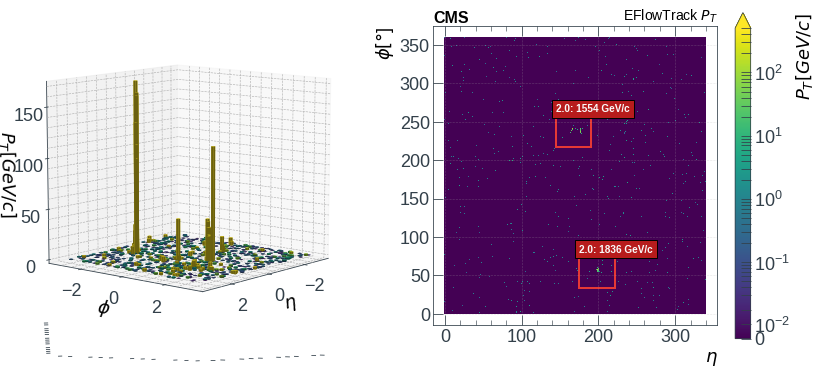

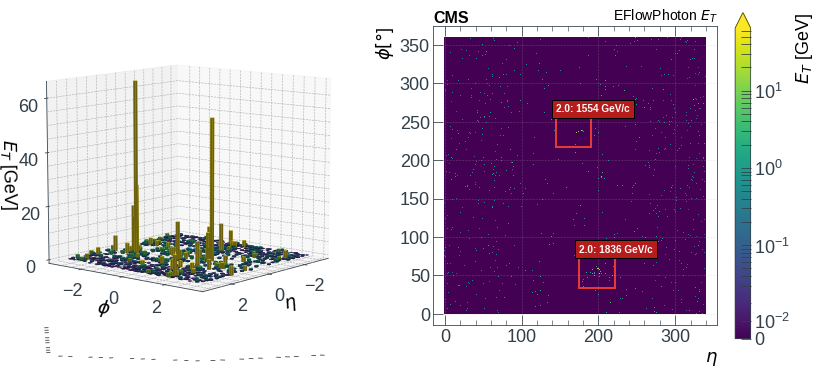

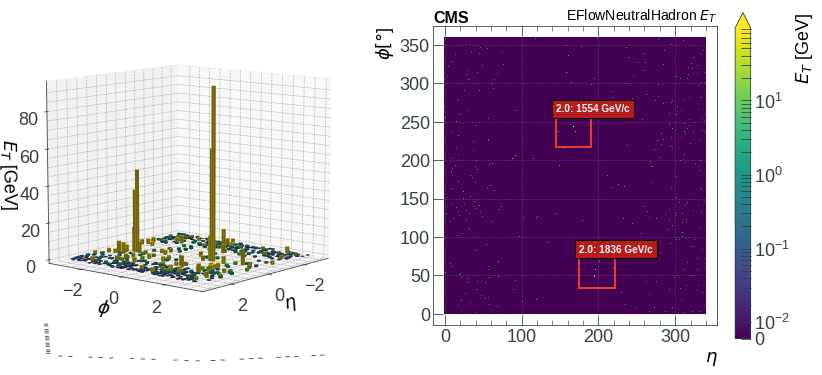

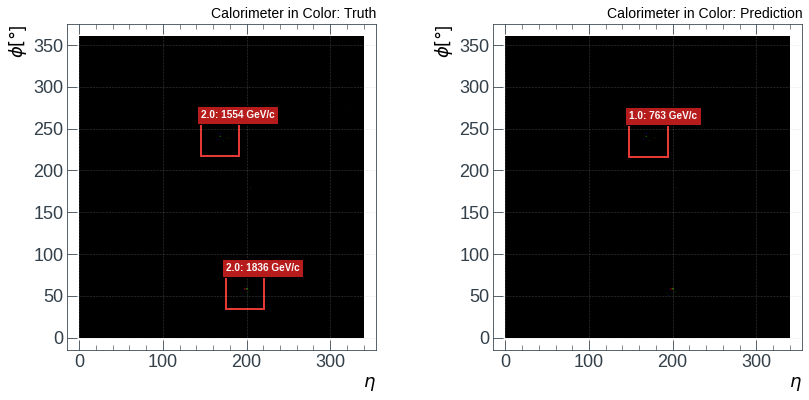

An example of event from RSGraviton_WW_NARROW_PU50_PF dataset


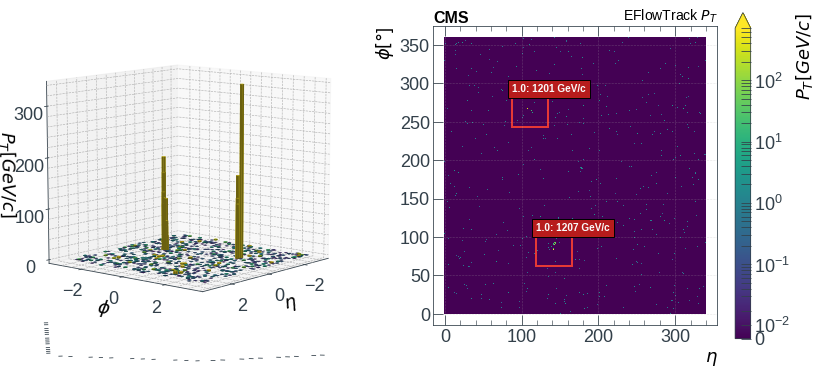

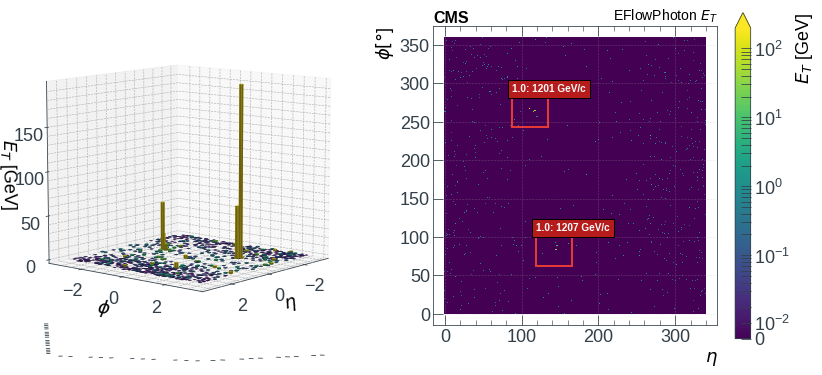

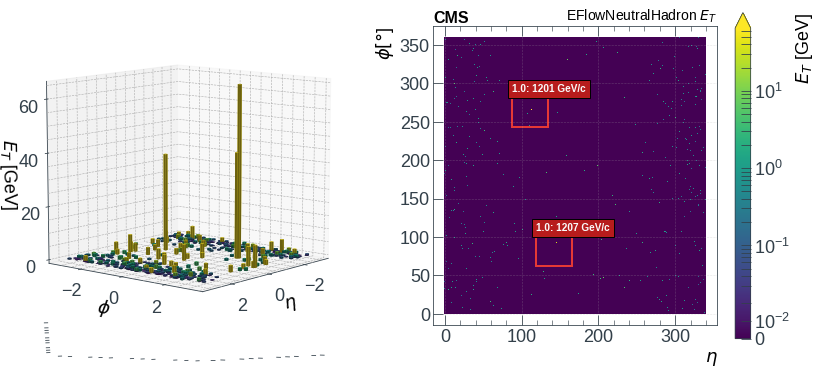

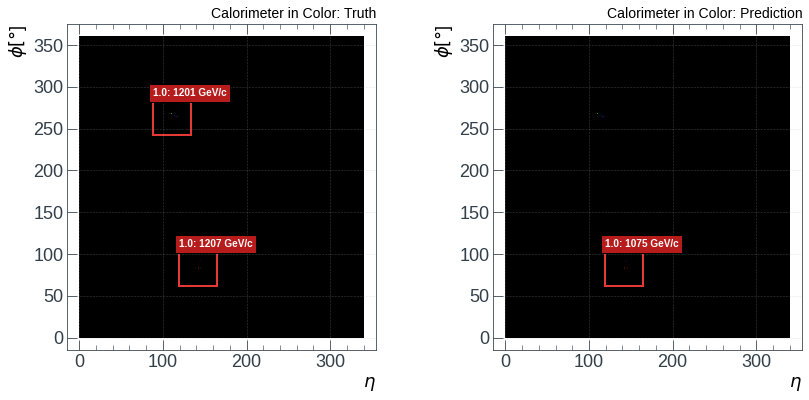

An example of event from RSGraviton_ZZ_NARROW_PU50_PF dataset


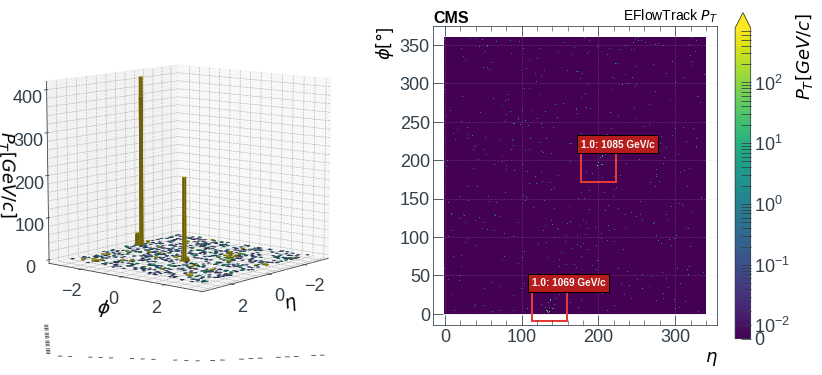

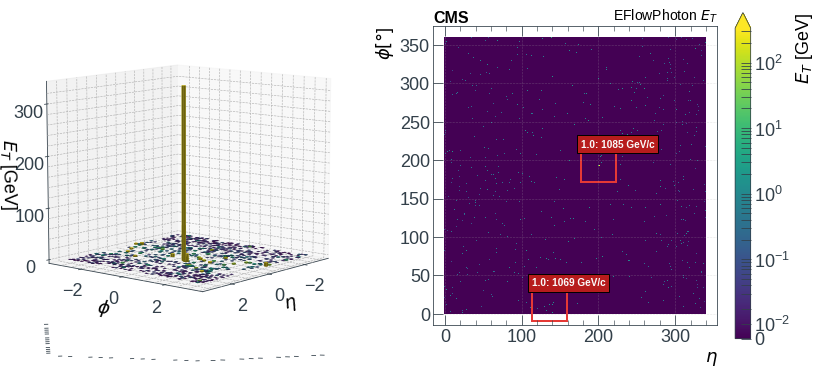

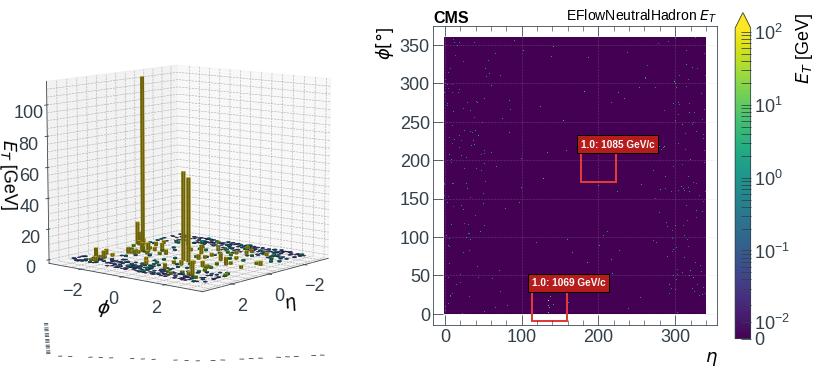

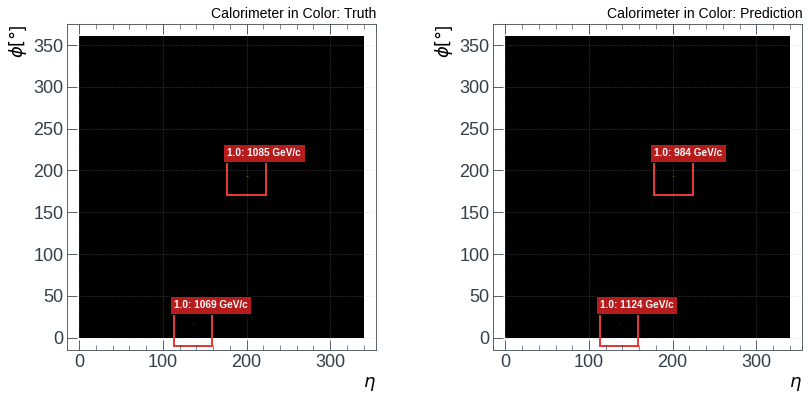

An example of event from RSGraviton_tt_NARROW_PU50_PF dataset


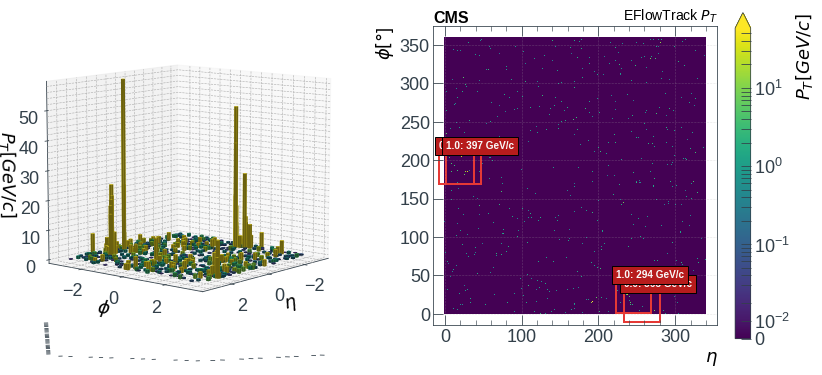

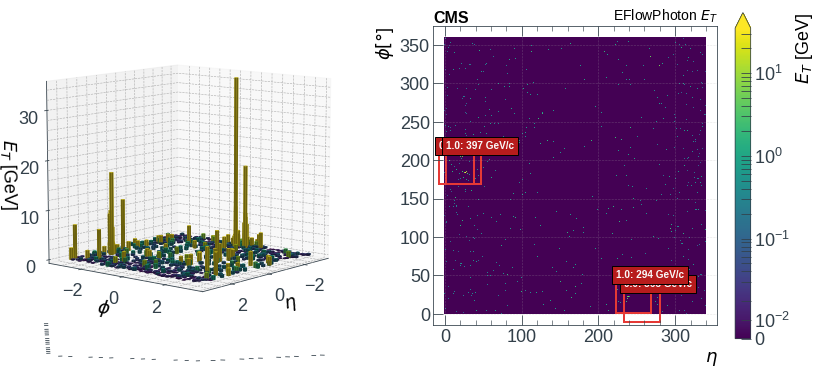

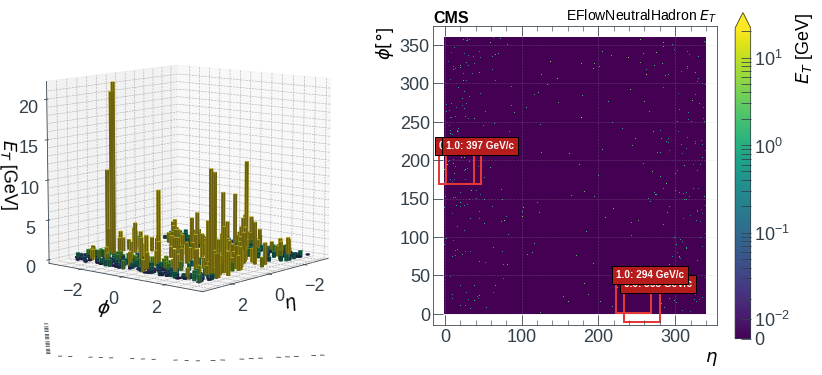

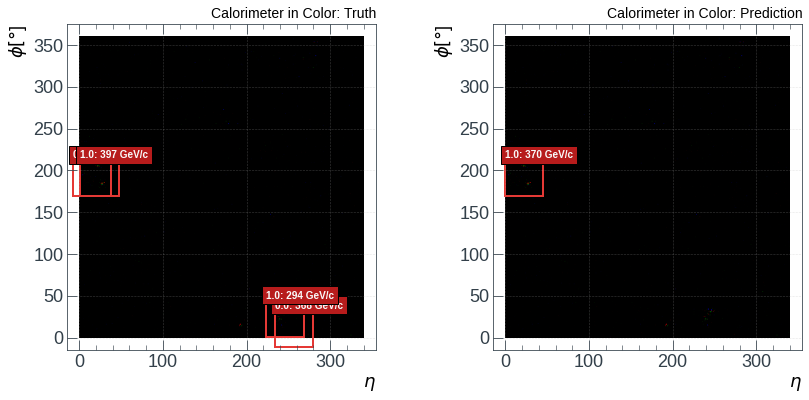

In [20]:
for dataset in ['RSGraviton_HH_NARROW_PU50_PF',
                'RSGraviton_WW_NARROW_PU50_PF',
                'RSGraviton_ZZ_NARROW_PU50_PF',
                'RSGraviton_tt_NARROW_PU50_PF']:

    print('An example of event from {0} dataset'.format(dataset))
    file_name = '{0}/{1}/{1}_0.root'.format(SOURCE_PATH, dataset)
    data_generator(file_name, 1)